## Quantum Neural Networks to predict Melting Points of Metal Oxides
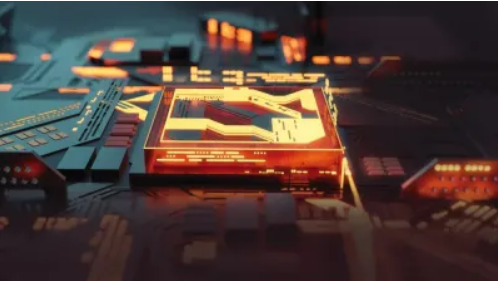
### Project for EP502 : Informatics for Materials Design, by Pourush Sharma, B22274

**Overview**: Quantum neural networks (QNNs) are variational quantum circuits used as ML models. They can use high-dimensional quantum states and inherit built-in regularization (unitarity) to mitigate overfitting. This makes them attractive for small-data problems like predicting material properties. Following Hirai et al., we build an encoder–ansatz–decoder QNN that learns to predict, e.g., melting points from material features. We outline steps for data preparation, circuit design, cost functions (with optional KL-divergence and entanglement metrics), optimization with Powell’s method, and evaluation (RMSE, diagnostics). We include Qiskit code snippets and discuss adapting to real hardware.

### Installing dependencies

In [275]:
%pip install qiskit pennylane torch scikit-learn numpy scipy matplotlib seaborn tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [276]:
%pip install pytket pytket-qiskit qualcs

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement qualcs (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for qualcs


### Data Preprocessing

**Dataset and scaling**: Explanatory variables are normalized to have a mean of 0 and a variance of 1. They are also scaled to have value between -1 and 1. The objective variable is divided by 3500 and scaled such that the maximum value was approximately 1 (the highest melting point of metal oxides treated in this study was 3390 °C).

In [277]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [278]:
data = pd.read_csv("data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   mpid                          70 non-null     object 
 1   formula_pretty                70 non-null     object 
 2   tmelt_C                       70 non-null     float64
 3   formation_energy_per_atom_eV  70 non-null     float64
 4   band_gap_eV                   70 non-null     float64
 5   density_g_cm3                 70 non-null     float64
 6   cati_anio_ratio               70 non-null     float64
 7   dist_from_o_A                 70 non-null     float64
 8    Ref                          70 non-null     object 
dtypes: float64(6), object(3)
memory usage: 5.1+ KB


,mpid,formula_pretty,tmelt_C,formation_energy_per_atom_eV,band_gap_eV,density_g_cm3,cati_anio_ratio,dist_from_o_A,Ref
0,mp-353,Ag20,230.0,-0.322979,0.0000,7.163038,2.000000,2.058538,S1
1,mp-1143,A|203,2025.0,-3.427314,5.8537,3.873499,0.666667,1.989267,S1
2,mp-306,B203,450.0,-2.798820,6.3017,2.561903,0.666667,1.370723,S1
3,mp-1342,BaO,1923.0,-2.824279,2.0906,5.859230,1.000000,2.790392,S1
4,mp-2542,BeO,2400.0,-3.103492,7.4639,3.019437,1.000000,2.684602,S1


In [279]:
feature_cols = [
 'formation_energy_per_atom_eV',
 'band_gap_eV',
 'density_g_cm3',
 'cati_anio_ratio',
 'dist_from_o_A']

target_col = 'tmelt_C'

X_raw = data[feature_cols].values
y_raw = data[target_col].values

scaler_X = StandardScaler()
X_norm = scaler_X.fit_transform(X_raw)

In [280]:
X_scaled = X_norm / np.max(np.abs(X_norm), axis=0)

for i in  y_raw:
    i = float(i)
y_scaled = (y_raw / 3500.0) * 2 - 1

**Train/Test Split:** 20% of the data (14 samples) are used as testing data and the remaining 80% (56 samples) are used as testing data.

In [281]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

**Encoder:** Each feature $x_i$ is loaded into one (or two) qubit(s) via a parameterized Ry rotation. For an $n$-
feature input and a “width” $w=1$ model, use $n$ qubits (5–10 qubits total as recommended) and
apply one of two encodings: linear or arctan.

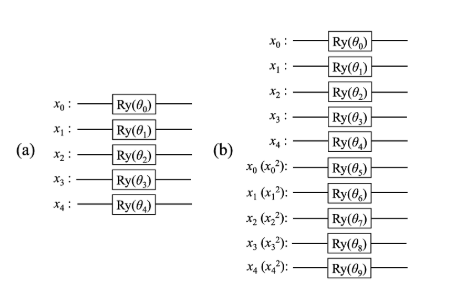

**Arctan vs linear encoding**: Each feature $x$ is encoded into a rotation angle $\theta$. As in the
reference, we can use either $$\theta = \pi x\,,\quad\text{or}\quad \theta = \arctan(x) + \frac{\pi}
{2}.$$ The latter “arctan” encoding uniquely maps even out-of-range values into angles . In
practice, the arctan rule often yields better performance for regression . We will use $
\theta = \arctan(x)+\pi/2$ by default unless otherwise noted.

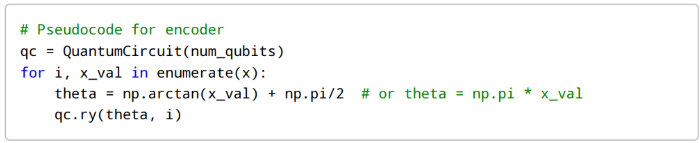

This prepares each qubit (initially |0⟩) in the state $R_y(\theta)|0⟩$, embedding the data . If
w=2 (as in a 10-qubit model), we can redundantly encode each feature into two qubits (e.g. duplicate
$x$ or use $(x, x^2)$) 

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

In [ ]:
from models import QNNEncoder

### Running the encoder

In [284]:
X_train[0]

array([-0.77216723,  0.30863784,  0.54823692, -0.0987163 ,  0.00716151])

In [285]:
encoder = QNNEncoder(n_qubits=5, encoding_method="arctan", redundant_encoding="quadratic")
circuit = encoder.create_encoding_circuit()

In [286]:
%pip install pylatexenc
%pip install qiskit[visualization]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


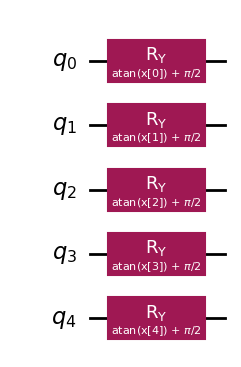

In [287]:
circuit.draw('mpl')

### Visualising on Bloch Sphere

In [288]:
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector
from qiskit.quantum_info import Statevector
import numpy as np

In [289]:
param_dict = dict(zip(encoder.features, X_train[0]))
bound_circuit = circuit.assign_parameters(param_dict)
statevector = Statevector(bound_circuit)

print("\nEncoder circuit:")
print(bound_circuit.draw())

statevector = Statevector(bound_circuit)
print("\nFinal statevector:")
print(statevector)


Encoder circuit:
     ┌─────────────┐
q_0: ┤ Ry(0.91326) ├
     └┬────────────┤
q_1: ─┤ Ry(1.8702) ├
      ├────────────┤
q_2: ─┤ Ry(2.0723) ├
      ├────────────┤
q_3: ─┤ Ry(1.4724) ├
      ├───────────┬┘
q_4: ─┤ Ry(1.578) ├─
      └───────────┘ 

Final statevector:
Statevector([0.14177557+0.j, 0.06964832+0.j, 0.19213188+0.j,
             0.09438624+0.j, 0.23941067+0.j, 0.1176123 +0.j,
             0.32444533+0.j, 0.15938623+0.j, 0.12846913+0.j,
             0.06311143+0.j, 0.17409922+0.j, 0.08552756+0.j,
             0.21694062+0.j, 0.10657372+0.j, 0.2939943 +0.j,
             0.14442693+0.j, 0.14279453+0.j, 0.0701489 +0.j,
             0.19351276+0.j, 0.09506461+0.j, 0.24113135+0.j,
             0.1184576 +0.j, 0.32677717+0.j, 0.16053176+0.j,
             0.12939246+0.j, 0.06356503+0.j, 0.17535049+0.j,
             0.08614226+0.j, 0.21849981+0.j, 0.10733969+0.j,
             0.29610728+0.j, 0.14546495+0.j],
            dims=(2, 2, 2, 2, 2))


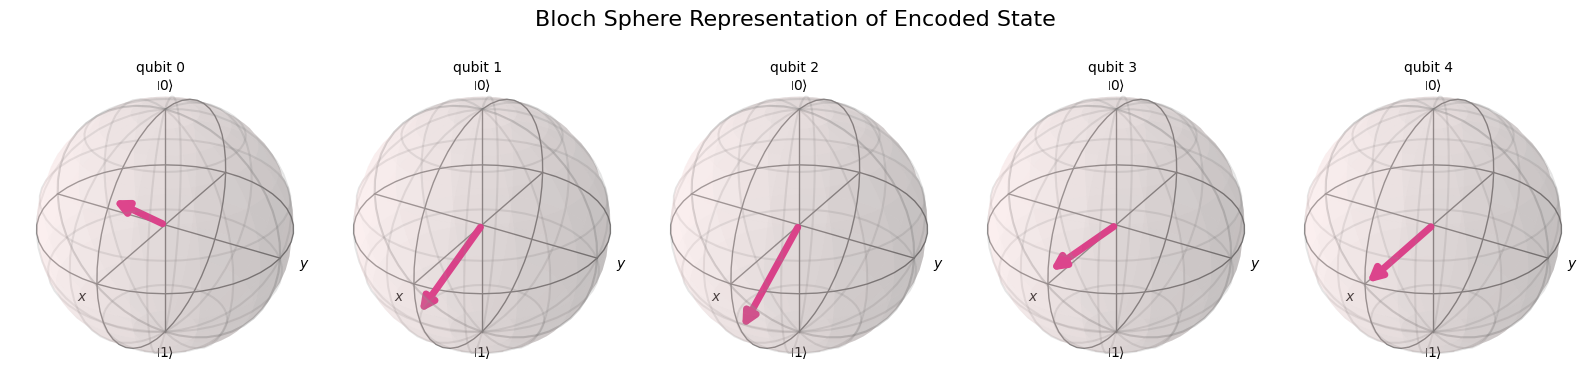

In [290]:
plot_bloch_multivector(statevector, title="Bloch Sphere Representation of Encoded State")

### Ansatz

In [291]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import CXGate, CZGate
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumRegister, ClassicalRegister

In [ ]:
from models import QNNAnsatz

### Full Quantum Circuit

In [293]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit import ParameterVector, Parameter
from qiskit.circuit.library import CXGate, CZGate
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2

In [ ]:
from models import QNN

# Utility functions for backward compatibility
from utils import add_measurement

### Testing 📿

In [296]:
qnn_5 = QNN(n_qubits = 5, depth = 2)
backend = GenericBackendV2(num_qubits= 5)

X = X_train[0]
ansatz_params_5 = np.random.random(10)  # 5 qubits * 2 depth

all_params_5 = np.concatenate((X, ansatz_params_5))
print(f"For 5 qubit model, parameter count is {len(all_params_5)}, and all params are {all_params_5}")

For 5 qubit model, parameter count is 15, and all params are [-0.77216723  0.30863784  0.54823692 -0.0987163   0.00716151  0.17701048
  0.08870253  0.12063587  0.46077877  0.20633372  0.36426986  0.50341727
  0.69039483  0.03931214  0.7994104 ]


In [297]:
circuit_5 = qnn_5.create_circuit()
print(f"5 qubit circuit depth: {circuit_5.depth()}")

5 qubit circuit depth: 10


In [298]:
exp_result = qnn_5.run_expectation(parameter_values = all_params_5)
print(f"Expectation value for 5 qubit model: {exp_result[0].data.evs}")

Expectation value for 5 qubit model: 0.1394866849234083


In [299]:
#Batch processing testing
batch_params = [all_params_5, all_params_5]
batch_result = qnn_5.run_batch_expectation(parameter_batch = batch_params)
print(f"Batch expectation value for 5 qubit model: {batch_result[0].data.evs}")

Batch expectation value for 5 qubit model: 0.1394866849234083


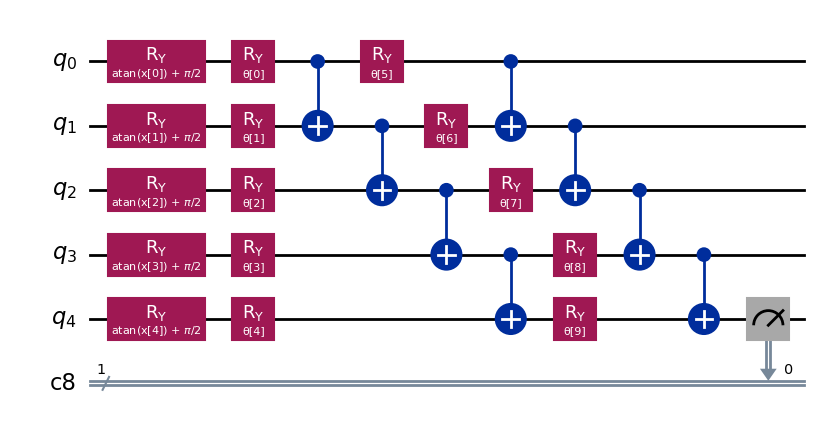

In [300]:
circuit_5.draw('mpl')

### Training!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
from typing import List, Tuple, Dict, Optional, Callable
import pickle

In [ ]:
from train import QNNTrainer

### Testing 💣

In [303]:
np.random.seed(42)
n_samples = 70
n_features = 5

In [304]:
X = np.random.randn(n_samples, n_features)
y = 1500 + 500 * np.sum(X, axis = 1) + 200 * np.random.randn(n_samples)
y = np.clip(y, 500, 3500)

In [305]:
print("=== QNN Training Example ===")
print(f"Dataset: {n_samples} samples, {n_features} features")
print(f"Target range: {y.min():.1f} - {y.max():.1f}°C")

=== QNN Training Example ===
Dataset: 70 samples, 5 features
Target range: 500.0 - 3500.0°C


In [306]:
qnn_5 = QNN(n_qubits=5, depth=2, encoding_method='arctan', entangler_type='linear')

In [307]:
print("\n--- Training QNN for 5 qubits ---")
trainer = QNNTrainer(qnn_5, optimizer='Powell', max_iterations=100)
results = trainer.train_single_fold(X, y, verbose=True)


--- Training QNN for 5 qubits ---
Starting optimization with Powell
Optimization completed in 81.13 seconds
Final train loss: 3195183.095876


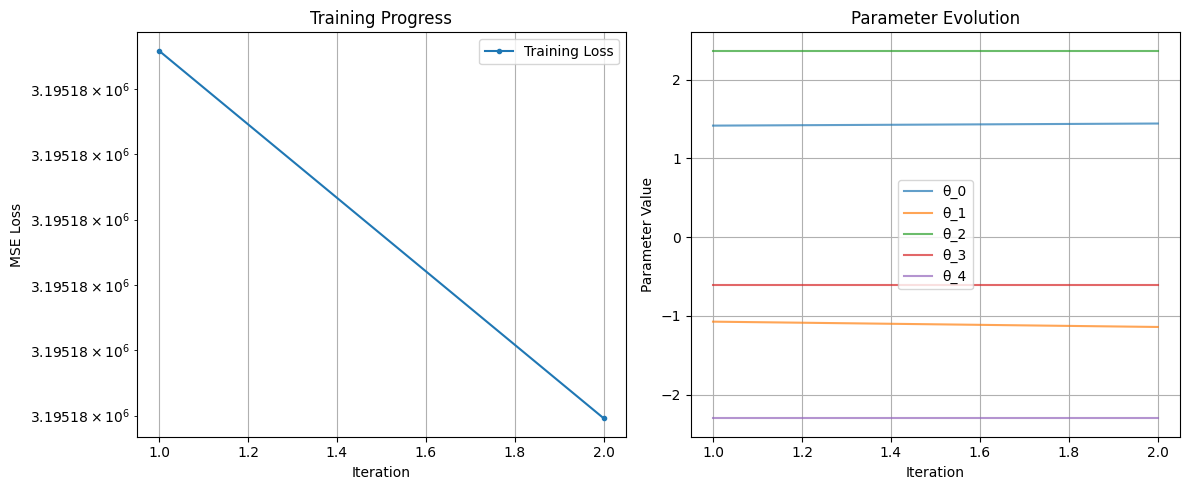

In [308]:
trainer.plot_training_history()

### Running the code on our actual data

In [309]:
print("=== QNN Training ===")
print(f"Dataset: {len(X_train)} samples, {len(X_train[0])} features")
print(f"Target range: {y_train.min():.1f} to {y_train.max():.1f}°C")

=== QNN Training ===
Dataset: 56 samples, 5 features
Target range: -1.0 to 0.9°C


In [310]:
qnn_5 = QNN(n_qubits=5, depth=2, encoding_method='arctan', entangler_type='linear')

In [311]:
print("\n--- Training QNN for 5 qubits ---")
trainer = QNNTrainer(qnn_5, optimizer='Powell', max_iterations=100)
results = trainer.train_single_fold(X_train, y_train, verbose=True)


--- Training QNN for 5 qubits ---
Starting optimization with Powell
Iteration 10: Train Loss = 0.065507
Optimization completed in 873.29 seconds
Final train loss: 0.065138


In [312]:
predictions = trainer.predict(X_test, use_best_params=True)
print(f"Predictions: {predictions}")

Predictions: [ 0.35303847 -0.48110603 -0.45824869  0.03274673 -0.25663199 -0.31775718
 -0.15383756 -0.35323886 -0.37656842 -0.51351869 -0.25997814 -0.43606207
 -0.06778497 -0.48273938]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator as RuntimeEstimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import seaborn as sns
import pandas as pd
from typing import Dict, List, Tuple, Optional
import time

In [ ]:
from evals import QNNEvaluator

In [ ]:
evaluator = QNNEvaluator(qnn_5, trainer)
test_results = evaluator.evaluate_test_set(X_test, y_test, verbose=True)
info = y_test

#evaluator.plot_evaluation_results(save_path="qnn_evaluation_plots.png")

=== Test Set Evaluation ===
Test Set Size: 14 samples
Prediction Time: 0.109 seconds (7.8 ms/sample)
RMSE: 0.30°C
MAE: 0.27°C
R² Score: 0.5495
Mean Relative Error: 212.40%
Max Absolute Error: 0.46°C
Residual Std: 0.29°C
✅ Excellent performance (RMSE < 100°C)


In [ ]:
predictions = test_results[1]

array([ 0.35303847, -0.48110603, -0.45824869,  0.03274673, -0.25663199,
       -0.31775718, -0.15383756, -0.35323886, -0.37656842, -0.51351869,
       -0.25997814, -0.43606207, -0.06778497, -0.48273938])

In [377]:
circuit = evaluator.prepare_optimized_circuit(X_test[0], optimization_level=3)

Circuit prepared:
  Qubits: 5
  Depth: 9
  Gates: {'ry': 15, 'cx': 8}


In [378]:
prep = evaluator.prepare_for_ibm_quantum(X_test[0], backend_name=None, optimization_level=3, shots=1024)
ibm_info = prep[0]
transpiled_circuit = prep[1]
bound_circuit = prep[2]

Circuit prepared:
  Qubits: 5
  Depth: 9
  Gates: {'ry': 15, 'cx': 8}
Falling back on fake backend, for real IBM backend, initialize QiskitRuntimeService
 Do: 
service:QiskitRuntimeService()
backend = service.backend(backend_name)

=== IBM Quantum Preparation ===
Backend: None
Original depth: 9
Transpiled depth: 18
Optimization level: 3
Ready for IBM Quantum execution!


### Our learnt circuit!

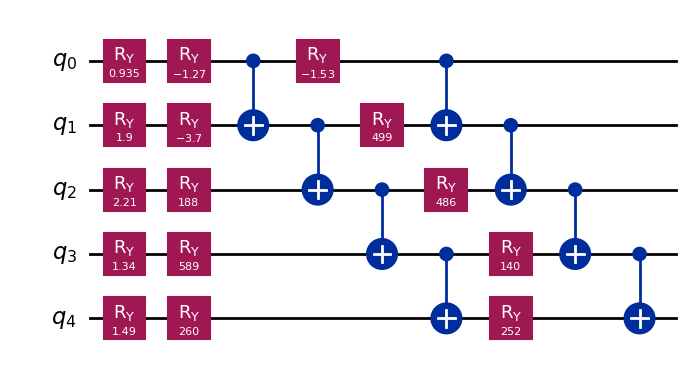

In [379]:
bound_circuit.draw('mpl')

### Circuit after transpilation

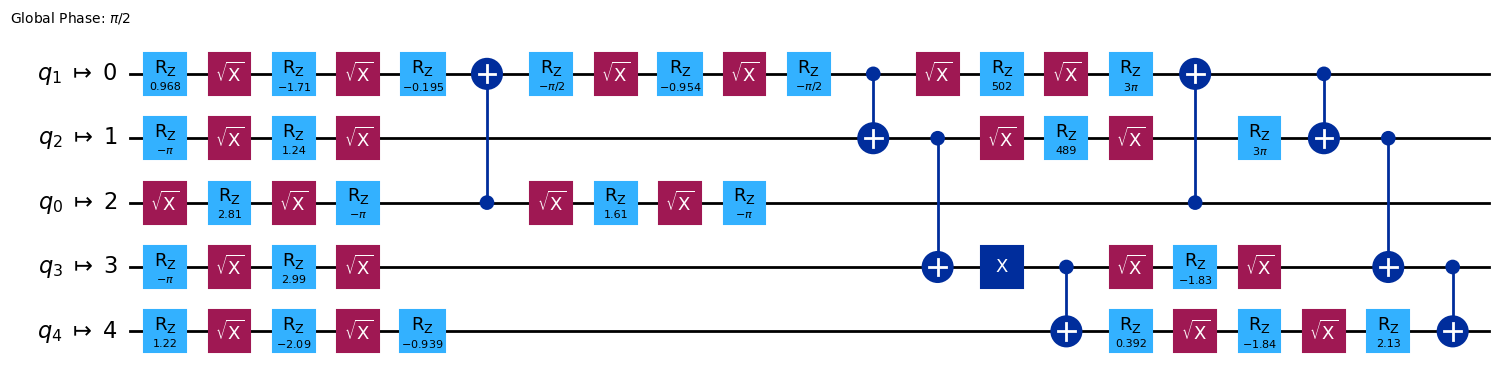

In [354]:
transpiled_circuit.draw('mpl')

## Running on a Real Quantum Computer! ✨

In [ ]:
API_TOKEN = "INSERT YOUR API TOKEN HERE"

In [361]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=API_TOKEN,
  channel="ibm_quantum" # `channel` distinguishes between different account types
)

In [362]:
service = QiskitRuntimeService()

C:\Users\pouru\AppData\Local\Temp\ipykernel_1068\1875822867.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


In [365]:
backend = service.least_busy()
print(f"Connected to {backend.name} backend")

Connected to ibm_brisbane backend


In [366]:
from qiskit.primitives import BaseEstimatorV2, BackendEstimatorV2

In [370]:
import qiskit

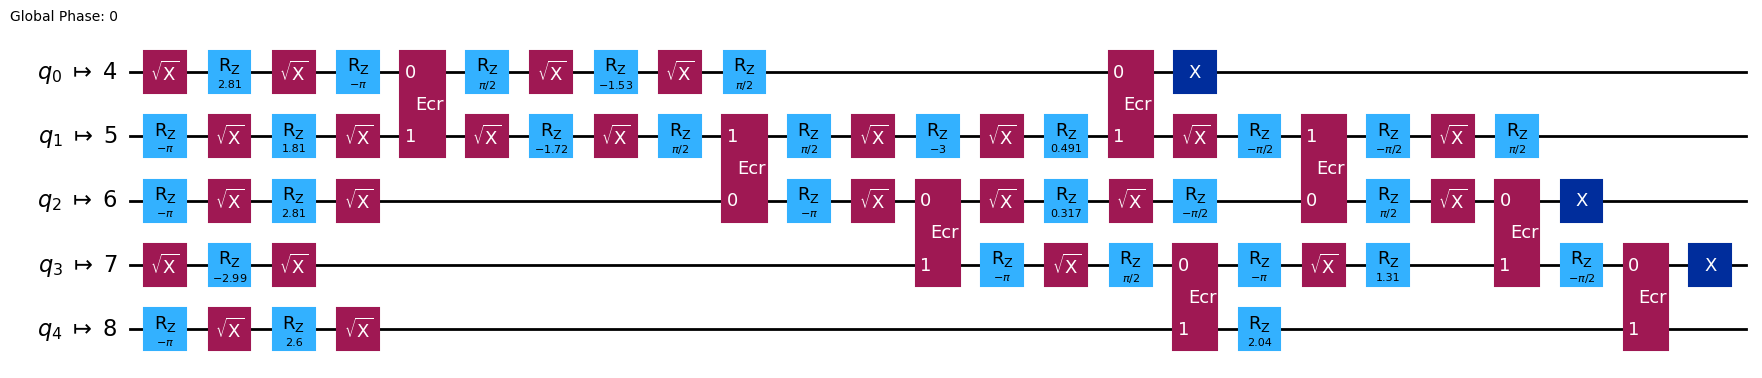

In [371]:

transpiled_circuit = qiskit.transpile(bound_circuit, backend=backend, optimization_level=3)
transpiled_circuit.draw('mpl')

In [382]:
from evals import return_predictions

In [386]:
predictions = return_predictions(X_test, transpiled_circuit, info)

In [387]:
predictions.sort()
y_test.sort()

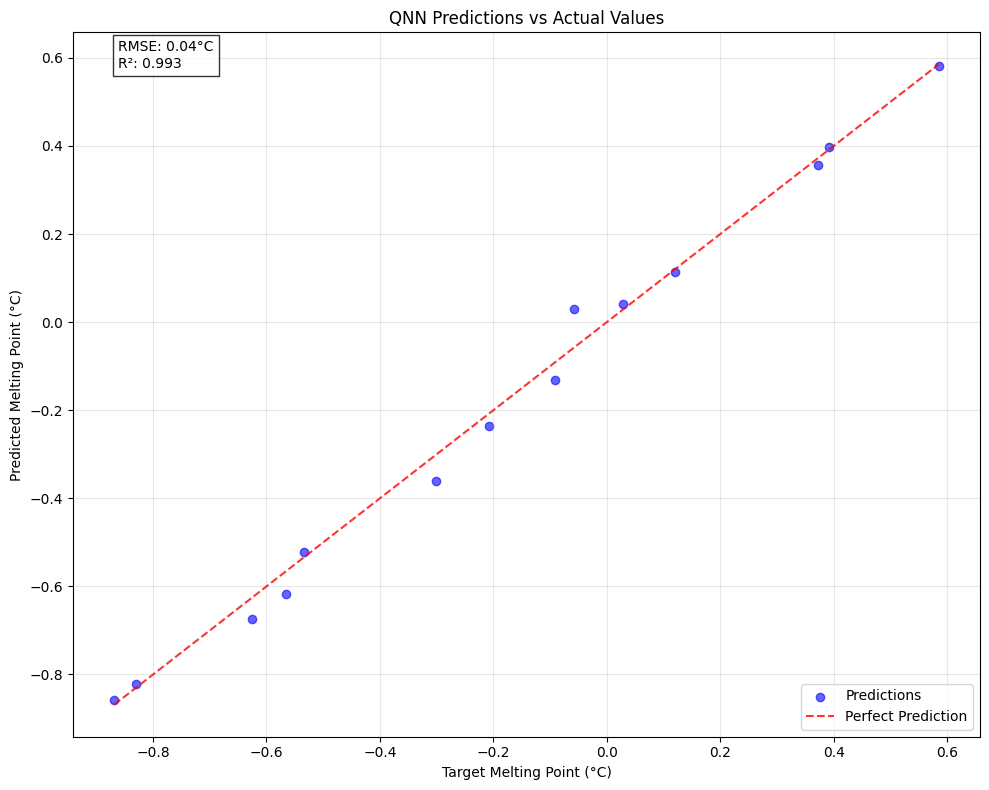

In [389]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', 
         label='Perfect Prediction', alpha=0.8)

plt.xlabel('Target Melting Point (°C)')
plt.ylabel('Predicted Melting Point (°C)')
plt.title('QNN Predictions vs Actual Values')
plt.grid(True, alpha=0.3)
plt.legend()

# Add text box with metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}°C\nR²: {r2:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()